In [981]:
import pandas as pd
import geopandas as gpd
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt
import folium
import sklearn
import math
import re
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
import graphviz 


sns.set(style="ticks", color_codes=True)
%matplotlib inline 

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [442]:
# read in data
def get_data(filename, headers = False, set_ind = False):
    if headers and isinstance(set_ind, int):
        data_df = pd.read_csv(filename, header = 0, index_col = set_ind)
    elif headers and not set_ind:
        data_df = pd.read_csv(filename, header = 0)
    else:
        data_df = pd.read_csv(filename)
    return data_df

In [443]:
source = "/Users/lorenh/Documents/Classes/Spring Quarter 2018/Machine Learning for Public Policy/Homework Assignments/HW2/credit-data.csv"

In [444]:
credit_df = get_data(filename = source, headers = True, set_ind = 0)

1


In [445]:
credit_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
PersonID,,,,,,,,,,,,
98976,0,1.000000,55,60601,0,505.000000,0.0,2,0,0,0,0.0
98991,0,0.547745,71,60601,0,0.459565,15666.0,7,0,2,0,0.0
99012,0,0.044280,51,60601,0,0.014520,4200.0,5,0,0,0,0.0
99023,0,0.914249,55,60601,4,0.794875,9052.0,12,0,3,0,0.0
99027,0,0.026599,45,60601,0,0.049966,10406.0,4,0,0,0,2.0


In [953]:
# explore statistics of all columns
credit_df.describe().round(3)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,41016.000,41016.000,41016.000,41016.000,41016.000,41016.000,41016.000,41016.000,41016.00,41016.000,41016.000,41016.000
mean,0.161,1.042,51.683,60623.824,0.589,309.365,6320.623,8.403,0.42,1.009,0.372,0.754
std,0.368,29.895,14.747,11.984,5.206,958.764,12080.558,5.207,5.19,1.154,5.170,1.114
min,0.000,0.000,21.000,60601.000,0.000,0.000,0.000,0.000,0.00,0.000,0.000,0.000
25%,0.000,0.034,41.000,60618.000,0.000,0.176,3800.000,5.000,0.00,0.000,0.000,0.000
50%,0.000,0.189,51.000,60625.000,0.000,0.369,5250.000,8.000,0.00,1.000,0.000,0.000
75%,0.000,0.664,62.000,60629.000,0.000,0.861,7245.500,11.000,0.00,2.000,0.000,1.000
max,1.000,1713.000,109.000,60644.000,98.000,11318.000,1794060.000,56.000,98.00,32.000,98.000,13.000


In [6]:
# Null frequency tabulation for each column
# Attribution: https://github.com/yhat/DataGotham2013/blob/master/analysis/main.py
def print_null_freq(df):
    """
    for a given DataFrame, calculates how many values for each variable is null
    and prints the resulting table to stdout
    """
    df_lng = pd.melt(df)
    null_variables = df_lng.value.isnull()
    print(pd.crosstab(df_lng.variable, null_variables))


In [986]:
copy_df = credit_df

In [864]:
def view_max_mins(df, max = True):
    if max:
        return df.quantile(q=np.arange(0.99, 1.001, 0.001))
    else: 
        return df.quantile(q=np.arange(0.0, 0.011, 0.001))

In [919]:
def view_likely_outliers(df, max = True):
    if max:
        return df.quantile(q=np.arange(0.9, 1.001, 0.001)).pct_change()
    else: 
        return df.quantile(q=np.arange(0.0, 0.011, 0.001)).pct_change()

In [918]:
def remove_over_threshold(df, col, threshold):
    maxes = view_max_mins(df, max = True)
    df.loc[df[col] > maxes.loc[threshold, col], col] = None
    
def remove_dramatic_outliers(df, outliers_df, max_min_df, col, threshold):
    outlier_values = list(max_min_df.loc[outliers_df[outliers_df[col] > threshold][col].index, col])
    df[~df[col].isin(outlier_values)]

In [883]:
likely_outliers_upper = view_likely_outliers(copy_df)
likely_outliers_upper

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0.990,1.0,1.159892,87.0,60644.0,4.0,4856.850,23000.00,25.0,4.000,5.0,2.0,4.0
0.991,1.0,1.194218,87.0,60644.0,5.0,5098.000,24000.00,25.0,4.000,5.0,2.0,4.0
0.992,1.0,1.246220,88.0,60644.0,5.0,5300.880,25000.00,25.0,4.000,5.0,3.0,4.0
0.993,1.0,1.294528,88.0,60644.0,5.0,5540.685,25833.00,26.0,4.000,5.0,3.0,4.0
0.994,1.0,1.375869,89.0,60644.0,5.0,5789.820,27982.00,27.0,5.000,6.0,3.0,5.0
0.995,1.0,1.459795,89.0,60644.0,6.0,6072.550,30000.00,27.0,6.000,6.0,3.0,5.0
0.996,1.0,1.618128,90.0,60644.0,6.0,6530.920,33560.48,28.0,7.000,6.0,4.0,5.0
0.997,1.0,1.817800,91.0,60644.0,9.0,7480.875,40000.00,30.0,10.955,7.0,6.0,5.0
0.998,1.0,2.050110,92.0,60644.0,98.0,8896.110,50485.00,32.0,98.000,8.0,98.0,5.0
0.999,1.0,3.525407,94.0,60644.0,98.0,11373.160,75000.00,35.0,98.000,10.0,98.0,6.0


In [ ]:
maxes = view_max_mins(copy_df, max = True)
maxes

In [ ]:
mins = view_max_mins(copy_df, max = False)
mins

In [ ]:
likely_outliers_lower = view_likely_outliers(copy_df, max = False)
likely_outliers_lower

In [987]:
remove_over_threshold(copy_df, 'RevolvingUtilizationOfUnsecuredLines', 0.999)

In [988]:
remove_over_threshold(copy_df, 'DebtRatio', 0.999)

In [989]:
print_null_freq(copy_df)

value                                     False  True 
variable                                              
DebtRatio                                 40974     42
DebtRatio_bin                             41016      0
MonthlyIncome                             41016      0
MonthlyIncome_bin                         41016      0
NumberOfDependents                        41016      0
NumberOfDependents_bin                    41016      0
NumberOfOpenCreditLinesAndLoans           41016      0
NumberOfOpenCreditLinesAndLoans_bin       41016      0
NumberOfTime30-59DaysPastDueNotWorse      41016      0
NumberOfTime30-59DaysPastDueNotWorse_bin  41016      0
NumberOfTime60-89DaysPastDueNotWorse      41016      0
NumberOfTime60-89DaysPastDueNotWorse_bin  41016      0
NumberOfTimes90DaysLate                   41016      0
NumberOfTimes90DaysLate_bin               41016      0
NumberRealEstateLoansOrLines              41016      0
NumberRealEstateLoansOrLines_bin          41016      0
RevolvingU

In [890]:
def basic_fill_vals(df, col_name, method = None):
    if method == "zeros":
        df[col_name] = df[col_name].fillna(0)
    elif method == "median":
        replacement_val = df[col_name].median()
        df[col_name] = df[col_name].fillna(replacement_val)
    elif method == "mean":
        replacement_val = df[col_name].mean()
        df[col_name] = df[col_name].fillna(replacement_val)

In [829]:
# fill null values  with basic 
basic_fill_vals(copy_df, "NumberOfDependents", method = "zeros")

In [830]:
basic_fill_vals(copy_df, "MonthlyIncome", method = "mean")

In [990]:
basic_fill_vals(copy_df, "RevolvingUtilizationOfUnsecuredLines", method = "median")

In [991]:
basic_fill_vals(copy_df, "DebtRatio", method = "median")

In [992]:
print_null_freq(copy_df)

value                                     False
variable                                       
DebtRatio                                 41016
DebtRatio_bin                             41016
MonthlyIncome                             41016
MonthlyIncome_bin                         41016
NumberOfDependents                        41016
NumberOfDependents_bin                    41016
NumberOfOpenCreditLinesAndLoans           41016
NumberOfOpenCreditLinesAndLoans_bin       41016
NumberOfTime30-59DaysPastDueNotWorse      41016
NumberOfTime30-59DaysPastDueNotWorse_bin  41016
NumberOfTime60-89DaysPastDueNotWorse      41016
NumberOfTime60-89DaysPastDueNotWorse_bin  41016
NumberOfTimes90DaysLate                   41016
NumberOfTimes90DaysLate_bin               41016
NumberRealEstateLoansOrLines              41016
NumberRealEstateLoansOrLines_bin          41016
RevolvingUtilizationOfUnsecuredLines      41016
RevolvingUtilizationOfUnsecuredLines_bin  41016
SeriousDlqin2yrs                        

### Feature Distribution

In [923]:
# view distributions of features
def view_dist(df, geo_columns):
    non_categoricals = isolate_noncategoricals(df, ret_categoricals = False, geo_cols = geo_columns)
    df[non_categoricals].hist(bins = 50, figsize=(20,15), color = 'blue')
    plt.show()

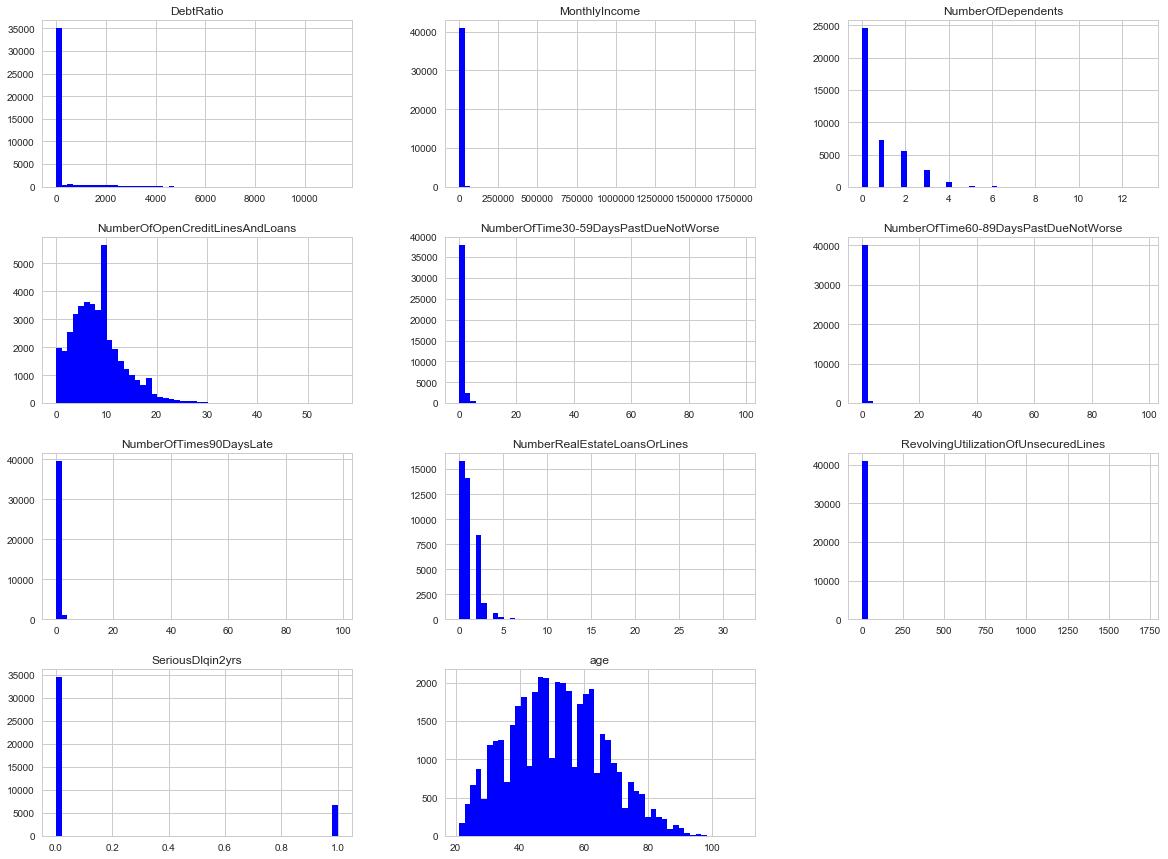

In [924]:
view_dist(copy_df, ["zipcode"])

In [81]:
# develop quick check of column position via dictionary
def create_col_ref(df):
    col_list = df.columns
    col_dict = {}
    for list_position, col_name in enumerate(col_list):
        col_dict[col_name] = list_position
    return col_dict

In [82]:
col_ref = create_col_ref(credit_df)
print(col_ref)

{'SeriousDlqin2yrs': 0, 'RevolvingUtilizationOfUnsecuredLines': 1, 'age': 2, 'zipcode': 3, 'NumberOfTime30-59DaysPastDueNotWorse': 4, 'DebtRatio': 5, 'MonthlyIncome': 6, 'NumberOfOpenCreditLinesAndLoans': 7, 'NumberOfTimes90DaysLate': 8, 'NumberRealEstateLoansOrLines': 9, 'NumberOfTime60-89DaysPastDueNotWorse': 10, 'NumberOfDependents': 11}


### Feature Correlation 

#### Pearson Correlation

There appears to be a significant amount of correlation between number of times 30-59 days late, the number of times 60-89 days late, and number of times 90+ days late, that is, a sample who has made a late payment in the 30-60 day window is likely to have also made late payments in the 60-90 day window and 90+ days after due date. As could be expected, the number of real estate loans or lines of credit is correlated with the total number of lines of credit or loans held by a sample. There appears to be relatively low correlation between other predictors.

In [611]:
def isolate_noncategoricals(df, ret_categoricals = False, geo_cols = None):
    if ret_categoricals:
        categorical = [col for col in df.columns if re.search("_bin", col)]
        return categorical + geo_cols
    else:
        non_categorical = [col for col in df.columns if not re.search("_bin", col) and col not in geo_cols]
        return non_categorical

In [705]:
# Check linear correlation between non-categorical variables
# Colormap Attribution: adapted from gradiated dataframe at https://www.datascience.com/blog/introduction-to-correlation-learn-data-science-tutorials 
# and correlation heatmap at https://stackoverflow.com/questions/29432629/correlation-matrix-using-pandas

def check_corr(df, geo_columns):  
    fig, ax = plt.subplots(figsize=(12, 12))
    non_categoricals = isolate_noncategoricals(df, ret_categoricals = False, geo_cols = geo_columns)
    
    corr = df[non_categoricals].corr(method="pearson")
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=plt.get_cmap("coolwarm"),
            square=True, ax=ax, annot=True)
    
    ax.set_xticks(range(len(non_categoricals)))
    ax.set_yticks(range(len(non_categoricals)))

    ax.tick_params(direction='inout')
    ax.set_xticklabels(non_categoricals, rotation=45, ha='right')
    ax.set_yticklabels(non_categoricals, rotation=45, va='top')
    plt.show()

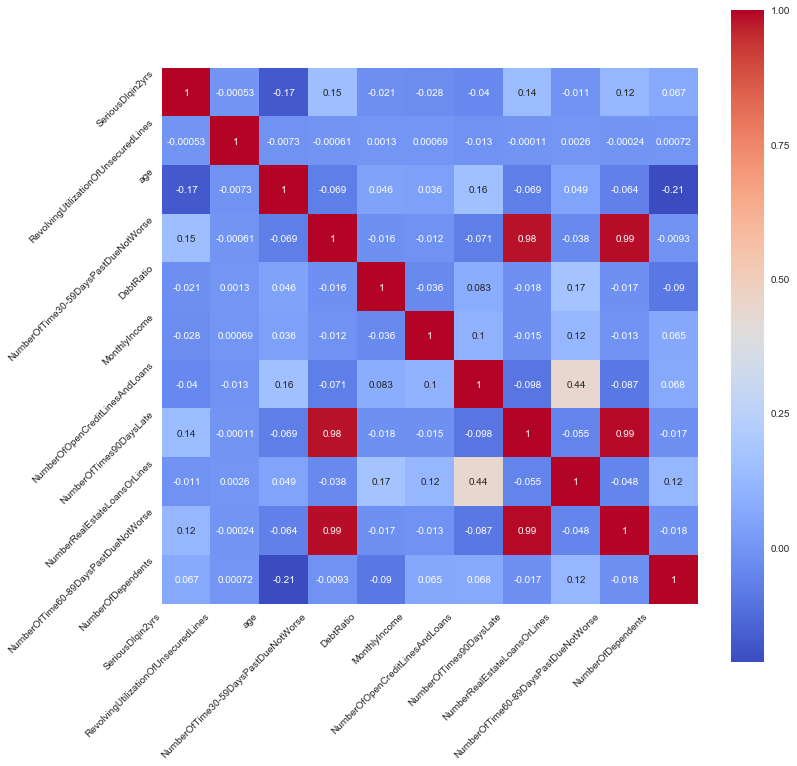

In [925]:
check_corr(copy_df, ["zipcode"])

#### Discretization of Non-categorical Variables

In [993]:
def discretize_cols(df, geo_columns, num_bins):
    non_categoricals = isolate_noncategoricals(df, ret_categoricals = False, geo_cols = geo_columns)
    for col in non_categoricals:
        bin_col = col + "_bin"
        if col == "age":
            age_bins = math.ceil((df[col].max() - df[col].min()) / 10)
            df[bin_col] = pd.cut(df[col], bins = age_bins, right = False, precision=0)
        else:
            try:
                df[bin_col] = pd.qcut(df[col], q = num_bins, precision=0)
            except:
                df[bin_col] = pd.qcut(df[col], q = num_bins + 3, precision=0, duplicates = 'drop')

In [894]:
discretize_cols(copy_df, ['zipcode'], 7)

In [895]:
copy_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,...,RevolvingUtilizationOfUnsecuredLines_bin,age_bin,NumberOfTime30-59DaysPastDueNotWorse_bin,DebtRatio_bin,MonthlyIncome_bin,NumberOfOpenCreditLinesAndLoans_bin,NumberOfTimes90DaysLate_bin,NumberRealEstateLoansOrLines_bin,NumberOfTime60-89DaysPastDueNotWorse_bin,NumberOfDependents_bin
PersonID,,,,,,,,,,,,,,,,,,,,,
98976,0,1.000000,55,60601,0,505.000000,0.0,2,0,0,...,"(0.9, 1713.0]","[50.0, 60.0)","(-1.0, 1.0]","(332.7, 106885.0]","(-1.0, 2267.0]","(-1.0, 3.0]","(-1.0, 98.0]","(-1.0, 1.0]","(-1.0, 98.0]","(-1.0, 1.0]"
98991,0,0.547745,71,60601,0,0.459565,15666.0,7,0,2,...,"(0.3, 0.6]","[70.0, 80.0)","(-1.0, 1.0]","(0.4, 0.7]","(10583.0, 1794060.0]","(5.0, 7.0]","(-1.0, 98.0]","(1.0, 2.0]","(-1.0, 98.0]","(-1.0, 1.0]"
99012,0,0.044280,51,60601,0,0.014520,4200.0,5,0,0,...,"(0.01, 0.05]","[50.0, 60.0)","(-1.0, 1.0]","(-0.1, 0.08]","(3330.0, 4230.0]","(3.0, 5.0]","(-1.0, 98.0]","(-1.0, 1.0]","(-1.0, 98.0]","(-1.0, 1.0]"
99023,0,0.914249,55,60601,4,0.794875,9052.0,12,0,3,...,"(0.6, 0.9]","[50.0, 60.0)","(1.0, 98.0]","(0.7, 332.7]","(8094.0, 10583.0]","(11.0, 14.0]","(-1.0, 98.0]","(2.0, 32.0]","(-1.0, 98.0]","(-1.0, 1.0]"
99027,0,0.026599,45,60601,0,0.049966,10406.0,4,0,0,...,"(0.01, 0.05]","[41.0, 50.0)","(-1.0, 1.0]","(-0.1, 0.08]","(8094.0, 10583.0]","(3.0, 5.0]","(-1.0, 98.0]","(-1.0, 1.0]","(-1.0, 98.0]","(1.0, 2.0]"


In [896]:
# observe distributions and correlations of features 
def plot_corr(df, geo_columns, color_category):
    non_categoricals = isolate_noncategoricals(df, ret_categoricals = False, geo_cols = geo_columns)
    plot_list = non_categoricals + [color_category]
    corr = sns.pairplot(df[plot_list], hue = color_category, palette = "Set2")

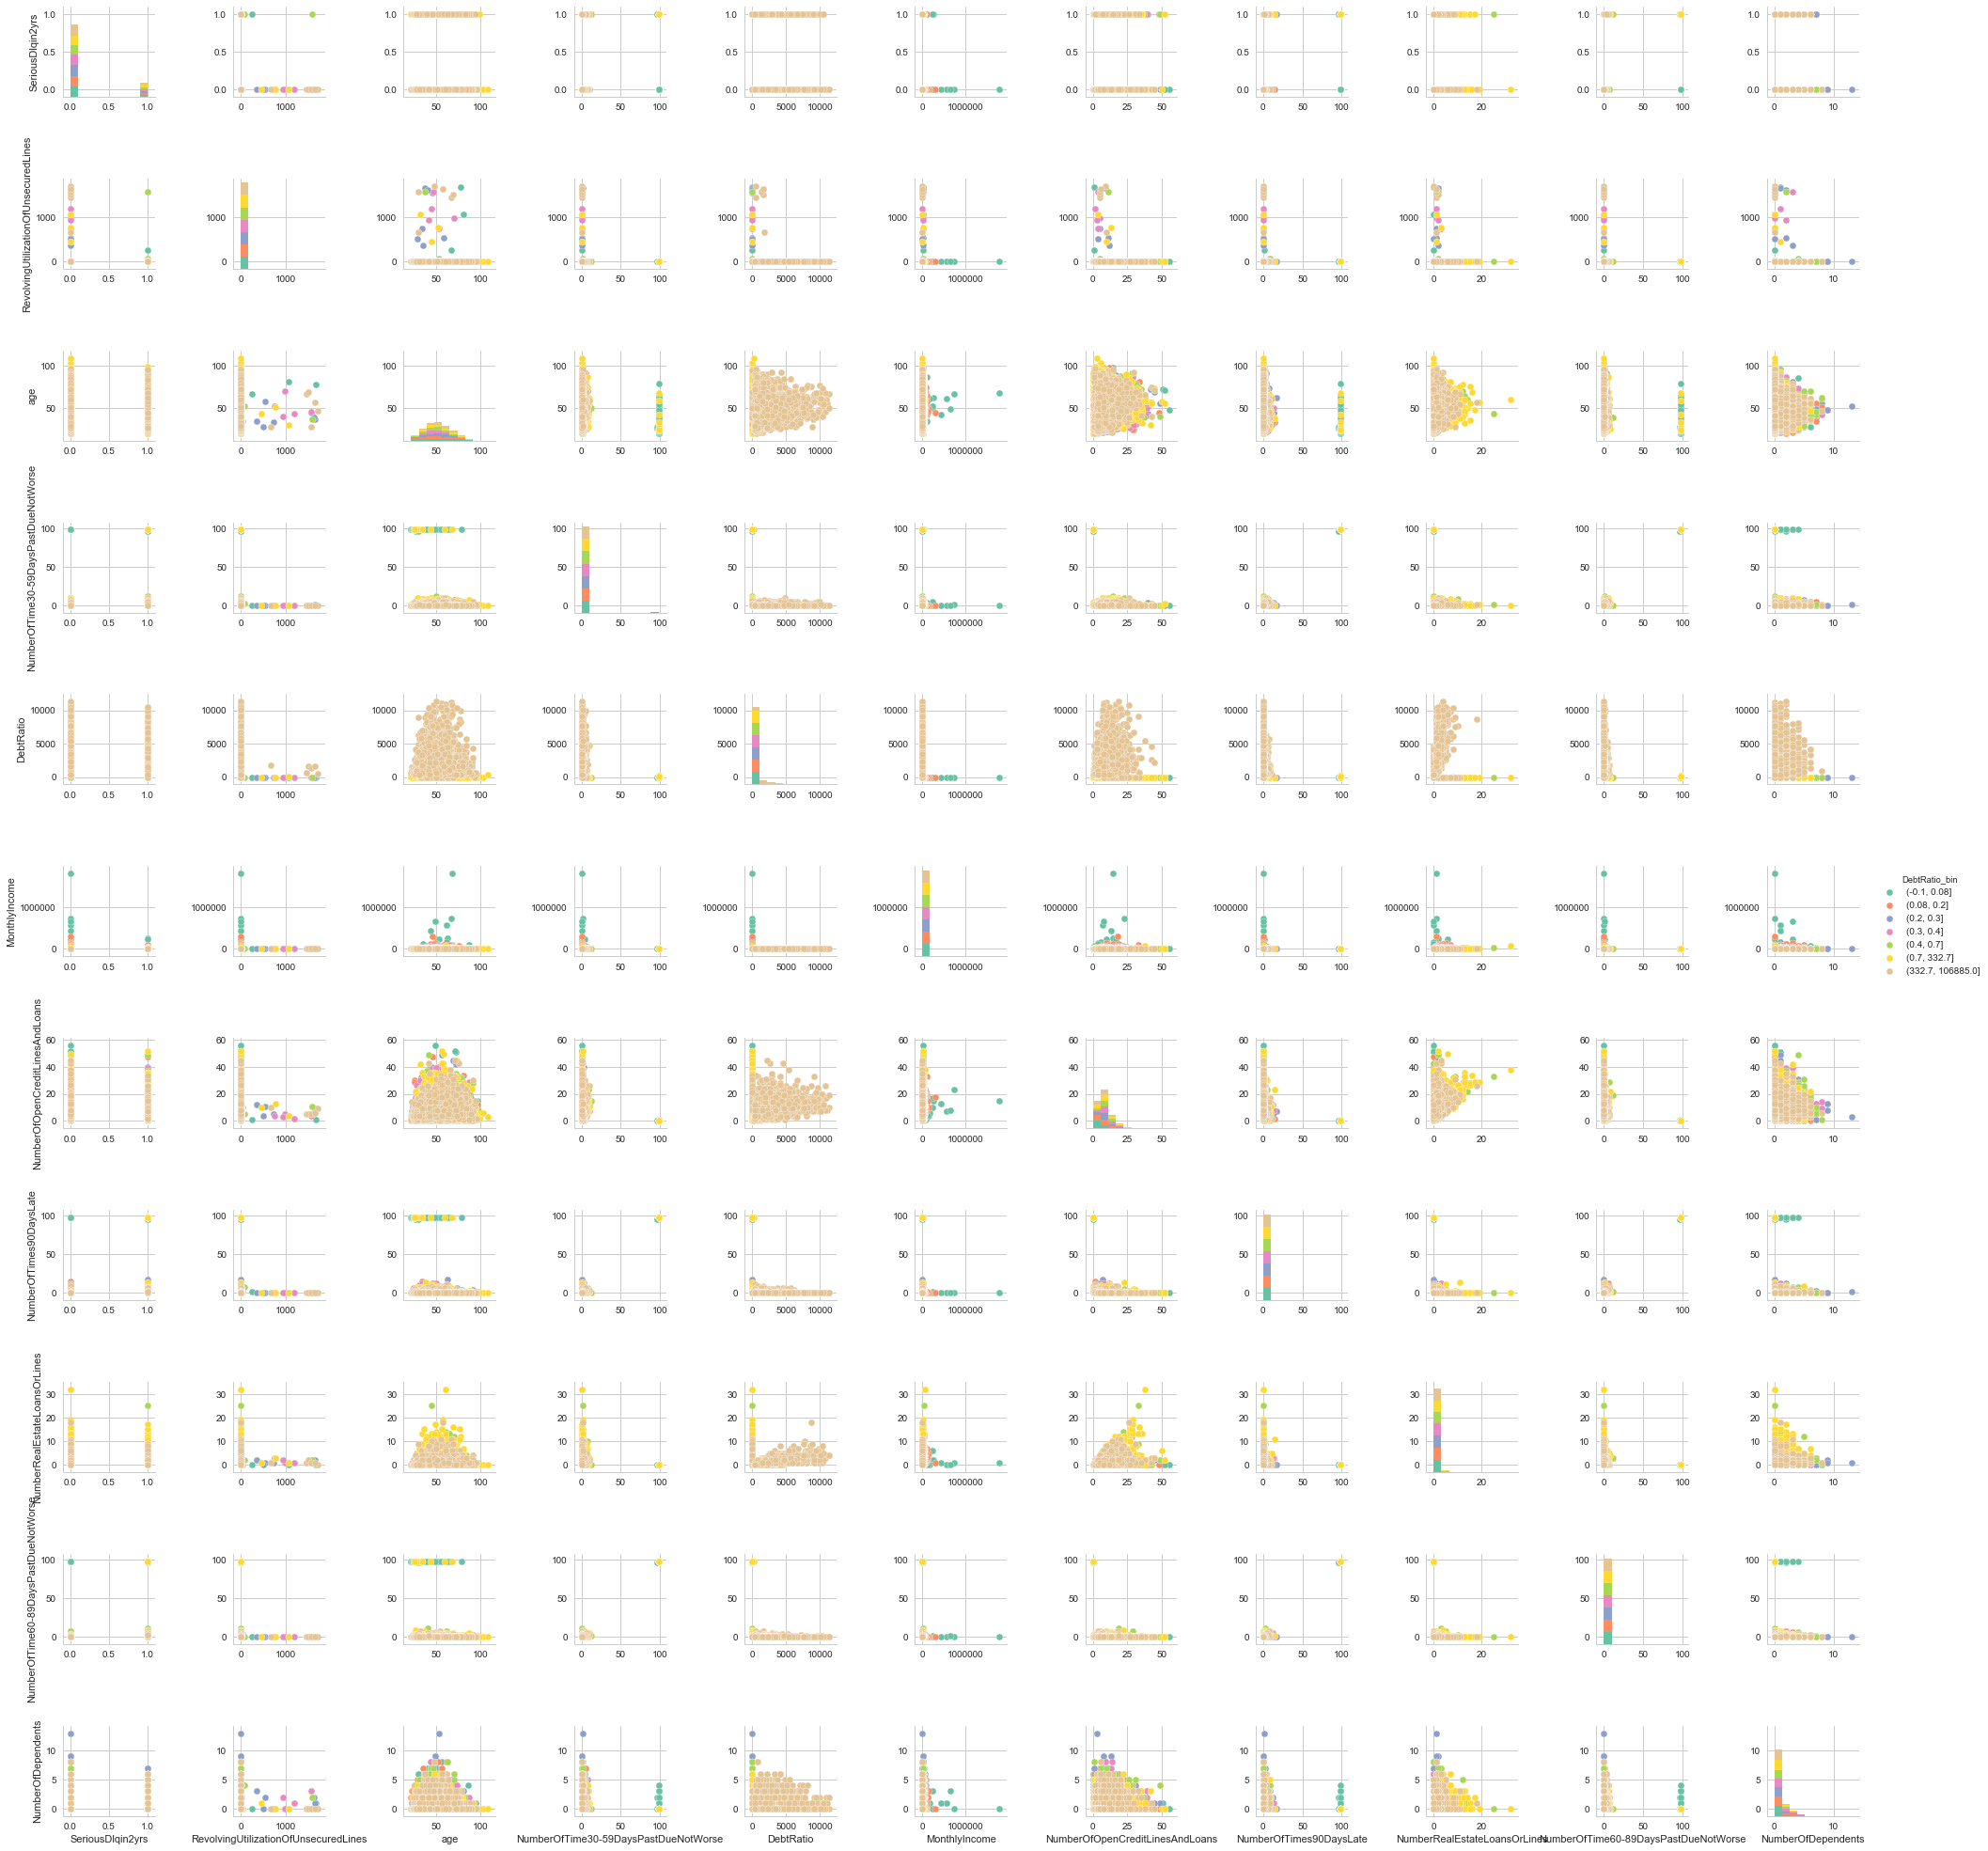

In [926]:
plot_corr(copy_df, geo_columns = ["zipcode"], color_category = "DebtRatio_bin")

#### Debt Ratio and Credit Utilization Breakdown by Age & Credit Utiliziation Breakdown by Debt Ratio 

Age alone does not appear to be a predicting debt ratio--each grouping of debt ratio appears to be spread fairly evenly across age groups, with most samples concentrated around median debt ratio value just below 0.4%. 

Though there appears to be a slight decline in utilization of credit in older age groups (80 years or older), there are far fewer samples in these age group, which could be influencing results with downward bias. Somewhat surprisingly, a higher debt ratio does not appear to be correlated with higher revolving credit utilization.


In [915]:
def plot_relationship(df, feature_x, xlabel,feature_y, ylabel, xlimit = None, ylimit = None, color_cat = None):
    '''
    Plot two features in a given data frame against each other to view relationship and outliers. 
    
    Attribution: adapted from https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Python_Seaborn_Cheat_Sheet.pdf
    '''
    sns.set_style("whitegrid")
    g = sns.lmplot(x = feature_x, y = feature_y, data = df, aspect = 3, hue = color_cat)
    g = (g.set_axis_labels(xlabel,ylabel)).set(xlim = xlimit , ylim = ylimit)
    plot_title = ylabel + " by " + xlabel
    plt.title(plot_title)
    plt.show(g)
    

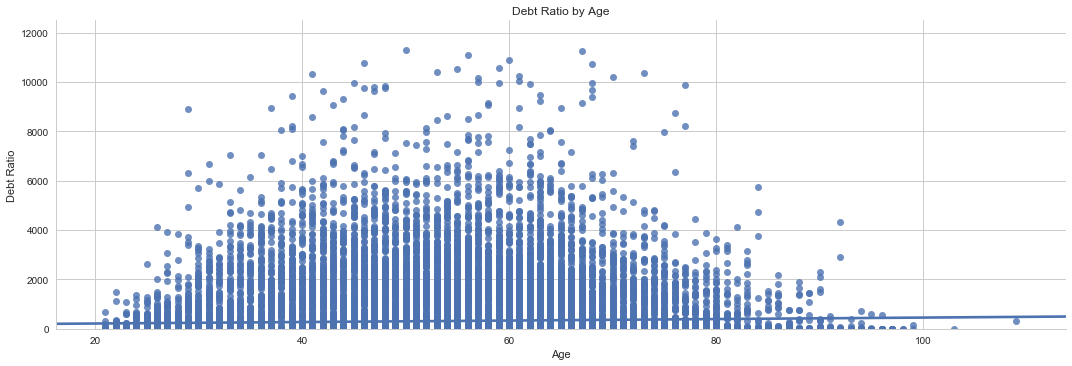

In [971]:
plot_relationship(copy_df, feature_y = 'DebtRatio', ylabel = 'Debt Ratio', feature_x = 'age', xlabel = 'Age',  ylimit = (0, 12500))

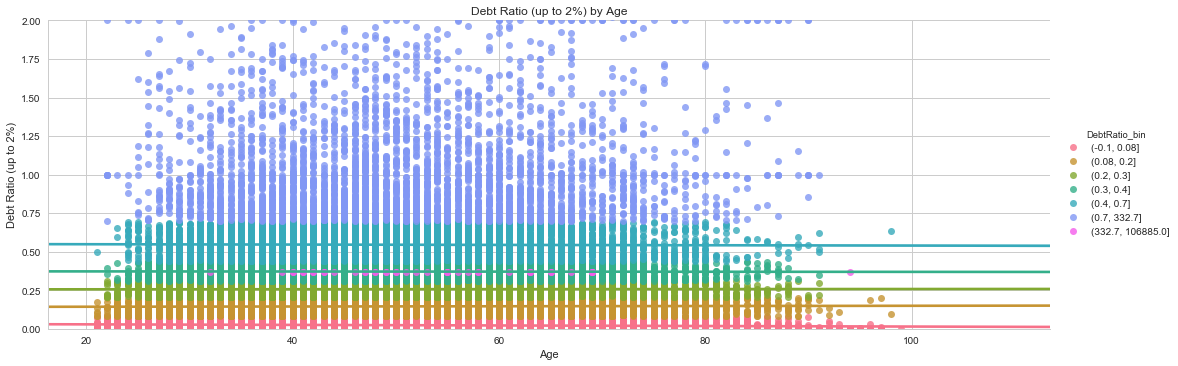

In [951]:
plot_relationship(copy_df, feature_x = 'age', xlabel = 'Age', feature_y = 'DebtRatio', ylabel = 'Debt Ratio (up to 2%)', ylimit = (0, 2), color_cat = 'DebtRatio_bin')

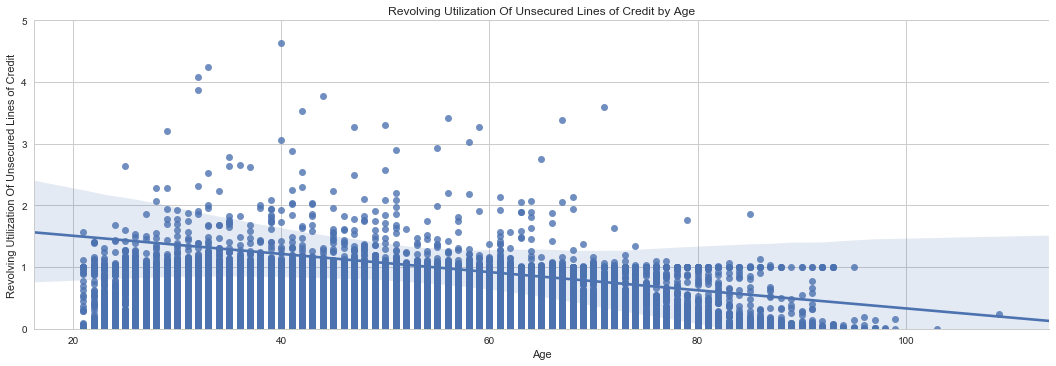

In [947]:
plot_relationship(copy_df, feature_x = 'age', xlabel = 'Age', feature_y = 'RevolvingUtilizationOfUnsecuredLines', ylabel = 'Revolving Utilization Of Unsecured Lines of Credit', ylimit = (0, 5))



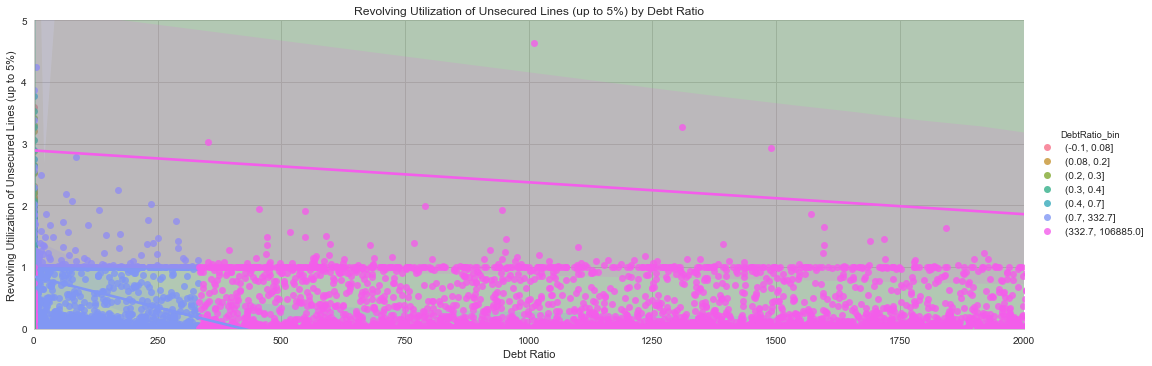

In [960]:
plot_relationship(copy_df, feature_x = 'DebtRatio', xlabel = 'Debt Ratio', feature_y = 'RevolvingUtilizationOfUnsecuredLines', ylabel = 'Revolving Utilization of Unsecured Lines (up to 5%)', xlimit = (0, 2000), ylimit = (0, 5), color_cat = 'DebtRatio_bin')



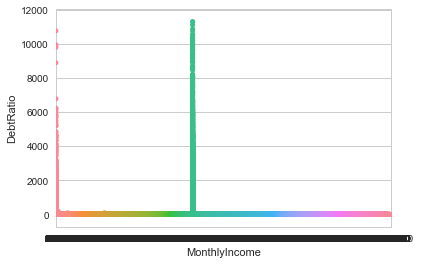

In [980]:
sns.swarmplot(x="MonthlyIncome",y="DebtRatio",data=copy_df)

### Open Credit Lines and Loans Breakdown by Debt Ratio, Age, and Zip Code

For the six zip codes included in sample, the median number of open credit lines majority of persons in the 31-79 age ran is 7-8, with a temporary jump in all zip codes to 9 in the 50-59 decade. only a portion of  samples in age ranges 41-69 had significantly more open lines of credit than other groups, with the vast majority in the 50-59 range.

In [710]:
def feature_by_geo(df, geo, expl_var, num_var, method = "median"):
    df_geo = df[(df[geo] != 0)]
    groupby_list = [geo] + expl_var
    if method == "median":
        geo_features = df_geo.groupby(groupby_list)[num_var].median().unstack(level = 1)
    if method == "count":
        geo_features = df_geo.groupby(groupby_list)[num_var].count().unstack(level = 1)
    geo_features.fillna(value = "", inplace = True)
    return geo_features

In [728]:
zip_open_credits_median = feature_by_geo(copy_df, geo = 'zipcode', expl_var = ["DebtRatio_bin"], num_var = "num_open_credits_loans")
zip_open_credits_median

DebtRatio_bin,"(-0.1, 0.08]","(0.08, 0.2]","(0.2, 0.3]","(0.3, 0.4]","(0.4, 0.7]","(0.7, 332.7]","(332.7, 106885.0]"
zipcode,,,,,,,
60601,4.0,7.0,8.0,9.0,10.0,8.0,8.0
60618,4.0,6.0,8.0,9.0,10.0,8.0,7.0
60625,4.0,7.0,8.0,9.0,10.0,8.0,7.5
60629,4.0,6.0,8.0,9.0,10.0,8.0,8.0
60637,4.0,6.0,8.0,9.0,10.0,7.0,8.0
60644,4.0,7.0,8.0,9.0,10.0,8.0,8.0


In [729]:
zip_open_credits_count = feature_by_geo(copy_df, 'zipcode', ["DebtRatio_bin"], "num_open_credits_loans", method = "count")
zip_open_credits_count

DebtRatio_bin,"(-0.1, 0.08]","(0.08, 0.2]","(0.2, 0.3]","(0.3, 0.4]","(0.4, 0.7]","(0.7, 332.7]","(332.7, 106885.0]"
zipcode,,,,,,,
60601,932,942,933,909,903,893,915
60618,886,896,881,913,914,939,903
60625,1834,1816,1828,1848,1887,1873,1818
60629,899,915,983,904,904,926,928
60637,914,893,881,905,911,916,933
60644,395,397,353,381,340,311,363


In [732]:
zip_open_credits_age_median = feature_by_geo(copy_df, 'zipcode', ["DebtRatio_bin", "age_bin"], "num_open_credits_loans")
zip_open_credits_age_median

DebtRatio_bin         (-0.1, 0.08] (0.08, 0.2] (0.2, 0.3] (0.3, 0.4]  \
zipcode age_bin                                                        
60601   [21.0, 31.0)             2           4          4          7   
        [31.0, 41.0)             3           6          7          8   
        [41.0, 50.0)             4           6          8          9   
        [50.0, 60.0)             4           7          9         10   
        [60.0, 70.0)             5           8          9         10   
        [70.0, 80.0)             5           9        9.5         10   
        [80.0, 89.0)             5           8         10       10.5   
        [89.0, 99.0)             5          11                         
        [99.0, 109.0)                                                  
60618   [21.0, 31.0)             2           4          5          7   
        [31.0, 41.0)             3           5          7          8   
        [41.0, 50.0)             4           7          7          8   
        [50.0, 60.0)             4         6.5          9         10   
        [60.0, 70.0)             6           7        9.5         10   
        [70.0, 80.0)             5           9          8         10   
        [80.0, 89.0)             5           8          8         11   
        [89.0, 99.0)             4         5.5        6.5              
60625   [21.0, 31.0)             2           4          6          7   
        [31.0, 41.0)             3           5          7          9   
        [41.0, 50.0)             4           6          8          9   
        [50.0, 60.0)             4           8          9         10   
        [60.0, 70.0)             6           8          9         10   
        [70.0, 80.0)             6           8          9        8.5   
        [80.0, 89.0)             5           8          8          9   
        [89.0, 99.0)             4           7          4          5   
60629   [21.0, 31.0)             2           4        5.5          6   
        [31.0, 41.0)             3         5.5          7          8   
        [41.0, 50.0)             4           6          8          9   
        [50.0, 60.0)             4           7        8.5         10   
        [60.0, 70.0)             5           7          9         10   
        [70.0, 80.0)             5           8         10          9   
        [80.0, 89.0)             5           8       10.5         10   
        [89.0, 99.0)             4          10                         
        [99.0, 109.0)                                                  
60637   [21.0, 31.0)             2           4          5          6   
        [31.0, 41.0)             3           5          7          7   
        [41.0, 50.0)             3           7          8          9   
        [50.0, 60.0)             5           7          9          9   
        [60.0, 70.0)             5           8          9         11   
        [70.0, 80.0)             6           9          9         10   
        [80.0, 89.0)             4           9          8         11   
        [89.0, 99.0)             3           4         13              
60644   [21.0, 31.0)             2           4          5          7   
        [31.0, 41.0)             4           6          7          7   
        [41.0, 50.0)             4           7          7          9   
        [50.0, 60.0)             5           8          9         11   
        [60.0, 70.0)             5           7         10         10   
        [70.0, 80.0)             6           6          8         11   
        [80.0, 89.0)             6           7          8         10   
        [89.0, 99.0)           3.5                                     

DebtRatio_bin         (0.4, 0.7]  (0.7, 332.7] (332.7, 106885.0]  
zipcode age_bin                                                   
60601   [21.0, 31.0)           7           3.0                 4  
        [31.0, 41.0)           9           8.0        

In [733]:
zip_open_credits_age_count = feature_by_geo(copy_df, 'zipcode', ["DebtRatio_bin", "age_bin"], "num_open_credits_loans", method = "count")
zip_open_credits_age_count

DebtRatio_bin         (-0.1, 0.08] (0.08, 0.2] (0.2, 0.3] (0.3, 0.4]  \
zipcode age_bin                                                        
60601   [21.0, 31.0)           155         110         57         42   
        [31.0, 41.0)           116         185        153        166   
        [41.0, 50.0)           127         209        260        282   
        [50.0, 60.0)           144         168        235        229   
        [60.0, 70.0)           169         166        159        127   
        [70.0, 80.0)           129          79         54         49   
        [80.0, 89.0)            74          23         15         14   
        [89.0, 99.0)            18           2                         
        [99.0, 109.0)                                                  
60618   [21.0, 31.0)           131         109         54         47   
        [31.0, 41.0)           136         186        145        167   
        [41.0, 50.0)           139         200        222        263   
        [50.0, 60.0)           140         184        245        238   
        [60.0, 70.0)           142         126        146        142   
        [70.0, 80.0)           121          67         52         45   
        [80.0, 89.0)            67          22         15         11   
        [89.0, 99.0)            10           2          2              
60625   [21.0, 31.0)           282         201        118         68   
        [31.0, 41.0)           255         331        300        365   
        [41.0, 50.0)           271         405        473        553   
        [50.0, 60.0)           296         376        478        464   
        [60.0, 70.0)           278         285        318        263   
        [70.0, 80.0)           261         165        110        110   
        [80.0, 89.0)           167          50         30         24   
        [89.0, 99.0)            24           3          1          1   
60629   [21.0, 31.0)           148         113         76         50   
        [31.0, 41.0)           124         194        167        187   
        [41.0, 50.0)           159         188        247        240   
        [50.0, 60.0)           126         184        240        228   
        [60.0, 70.0)           144         154        177        139   
        [70.0, 80.0)           116          56         64         51   
        [80.0, 89.0)            64          23         12          9   
        [89.0, 99.0)            18           3                         
        [99.0, 109.0)                                                  
60637   [21.0, 31.0)           144         104         60         43   
        [31.0, 41.0)           127         167        165        178   
        [41.0, 50.0)           153         213        216        277   
        [50.0, 60.0)           140         182        228        228   
        [60.0, 70.0)           138         138        130        128   
        [70.0, 80.0)           119          62         62         44   
        [80.0, 89.0)            81          24         19          7   
        [89.0, 99.0)            12           3          1              
60644   [21.0, 31.0)            50          42         20         14   
        [31.0, 41.0)            56          69         64         58   
        [41.0, 50.0)            58          85         91        109   
        [50.0, 60.0)            52          90         93        102   
        [60.0, 70.0)            57          69         59         68   
        [70.0, 80.0)            71          30         18         25   
        [80.0, 89.0)            41          12          8          5   
        [89.0, 99.0)            10                                     

DebtRatio_bin         (0.4, 0.7]  (0.7, 332.7] (332.7, 106885.0]  
zipcode age_bin                                                   
60601   [21.0, 31.0)          40          67.0                35  
        [31.0, 41.0)         171         160.0        

In [1008]:
def create_binary_vars(df, cols_to_dummy, keyword_list):
    '''
    Create binary variable corresponding to values above zero for selected columns in a given dataframe based on common keywords
    '''
    keyword_string = ("|").join(keyword_list)
    for col in cols_to_dummy:
        colname_trunc = re.sub(keyword_string, '', col)
        binary_col_name = 'tf_' + colname_trunc
        df[binary_col_name] = df[col].apply(lambda x: x > 0)

In [1009]:
to_dummy = ['SeriousDlqin2yrs', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse','NumberOfDependents']
dummy_flags = ['NumberOfTimes', 'NumberOfTime', 'NumberOf']

In [1010]:
create_binary_vars(copy_df, to_dummy, dummy_flags)

In [1011]:
copy_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,...,NumberOfOpenCreditLinesAndLoans_bin,NumberOfTimes90DaysLate_bin,NumberRealEstateLoansOrLines_bin,NumberOfTime60-89DaysPastDueNotWorse_bin,NumberOfDependents_bin,tf_SeriousDlqin2yrs,tf_30-59DaysPastDueNotWorse,tf_90DaysLate,tf_60-89DaysPastDueNotWorse,tf_Dependents
PersonID,,,,,,,,,,,,,,,,,,,,,
98976,0,1.000000,55,60601,0,505.000000,0.0,2,0,0,...,"(-1.0, 3.0]","(-1.0, 98.0]","(-1.0, 1.0]","(-1.0, 98.0]","(-1.0, 1.0]",False,False,False,False,False
98991,0,0.547745,71,60601,0,0.459565,15666.0,7,0,2,...,"(5.0, 7.0]","(-1.0, 98.0]","(1.0, 2.0]","(-1.0, 98.0]","(-1.0, 1.0]",False,False,False,False,False
99012,0,0.044280,51,60601,0,0.014520,4200.0,5,0,0,...,"(3.0, 5.0]","(-1.0, 98.0]","(-1.0, 1.0]","(-1.0, 98.0]","(-1.0, 1.0]",False,False,False,False,False
99023,0,0.914249,55,60601,4,0.794875,9052.0,12,0,3,...,"(11.0, 14.0]","(-1.0, 98.0]","(2.0, 32.0]","(-1.0, 98.0]","(-1.0, 1.0]",False,True,False,False,False
99027,0,0.026599,45,60601,0,0.049966,10406.0,4,0,0,...,"(3.0, 5.0]","(-1.0, 98.0]","(-1.0, 1.0]","(-1.0, 98.0]","(1.0, 2.0]",False,False,False,False,True
